# Reinforcement learning

In [237]:
import numpy as np
import keras_tuner
import keras
import pandas as pd
from dataclasses import dataclass

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten, Conv2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from imblearn.combine import SMOTEENN

pd.options.display.max_columns = 200
keras.utils.set_random_seed(42)

In [238]:
@dataclass
class ProcessedData:
  def __init__(self, X, y):
    self.X = X.copy()
    self.y = y.copy(deep=True)

  def copy(self):
    return ProcessedData(self.X.copy(), self.y.copy())

In [239]:
#X = pd.read_csv("./data/4/X.csv", header=None)
y = pd.read_csv("./data/y.csv", header=None)
X = pd.read_csv("./data/diff.csv", header=None)
print(y.shape)
#print(X.shape)
print(X.shape)

(11094, 1)
(11094, 2040)


In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [241]:
smoteenn = SMOTEENN(random_state=42)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

In [242]:
X_train = X_train.to_numpy().reshape(-1, 40, 51, 1)
X_test = X_test.to_numpy().reshape(-1, 40, 51, 1)

In [243]:
X_train.shape

(19727, 40, 51, 1)

In [244]:
y_train.groupby(0)[0].count()

0
0    6048
1    6986
2    6693
Name: 0, dtype: int64

# The dataset is not balanced

In [245]:
sklearn_class_weights = compute_class_weight(class_weight="balanced", classes=y[0].unique(), y=y[0])
class_weight = {}
for i, weight in enumerate(sklearn_class_weights):
    class_weight[i] = weight
    #if i != 0:
    #    class_weight[i] *= 2
    
print(class_weight)

{0: 0.390084388185654, 1: 5.519402985074627, 2: 3.917372881355932}


In [246]:
#X_train, X_test, y_train, y_test = train_test_split(X_res_2D, y_res)

In [247]:
train = ProcessedData(X_train, y_train)
test = ProcessedData(X_test, y_test)

In [248]:
# Extension de la classe BayesianOptimization pour permettre l'accès aux historiques des modèles entrainés.
class BayesianOptimization(keras_tuner.BayesianOptimization):
    histories = {}

    # À la fin de chaque époque, on ajoute les métriques à l'historique de l'essai en cours
    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items():
            trial_history.setdefault(metric, []).append(value)

In [249]:
def build_model(hp):
    
    input = Input(shape=(40, 51, 1))
    # Optimisation du réseau de neurone

    if hp.Boolean("Dense", default=False):
        x = Flatten()(input)
        x = Dense(hp.Int(f'units_0', 8, 64, step=16), activation='relu')(x)
        for i in range(hp.Int('nbDense', 0, 4)):
            x = Dense(hp.Int(f'dense_units_{str(i+1)}', 8, 64, step=16), activation='relu')(x)
    else:
        x = Conv2D(hp.Int(f'filter_0', 3, 9, step=3), hp.Int(f'kernel_size_0', 3, 5, step=2), activation='relu')(input)
        for i in range(hp.Int('nbConvolution', 0, 4)):
            x = Conv2D(hp.Int(f'conv_filter_{str(i+1)}', 3, 9, step=3), hp.Int(f'kernel_size_{str(i+1)}', 3, 9, step=2), activation='relu')(x)
        x = Flatten()(x)

    output = Dense(3, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', weighted_metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=8)

early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='max', baseline=None, restore_best_weights=True)
tuner.search(train.X, train.y, validation_split=0.2, epochs=1000, callbacks=[early_stopping_cb])

Trial 8 Complete [00h 00m 25s]
val_accuracy: 0.9787126183509827

Best val_accuracy So Far: 0.9875823855400085
Total elapsed time: 00h 11m 35s


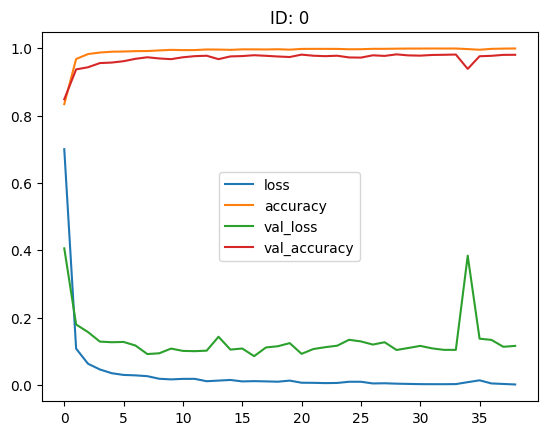

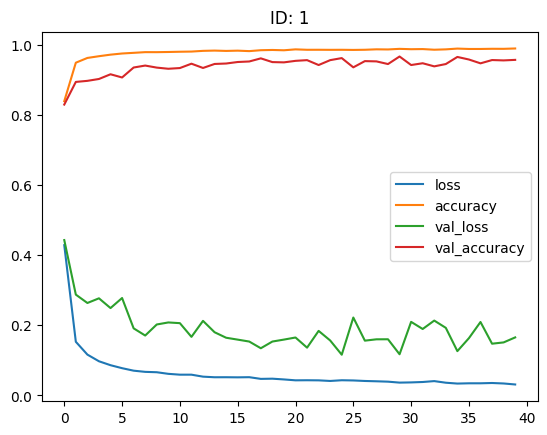

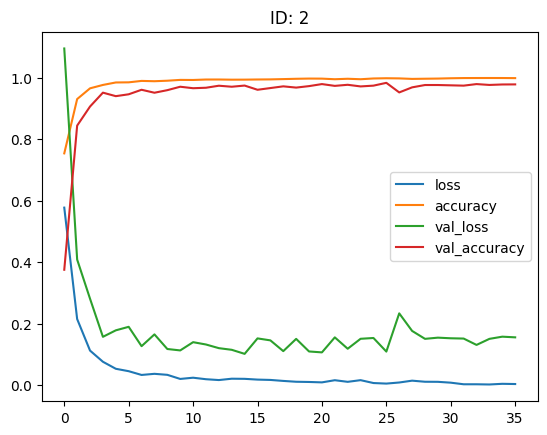

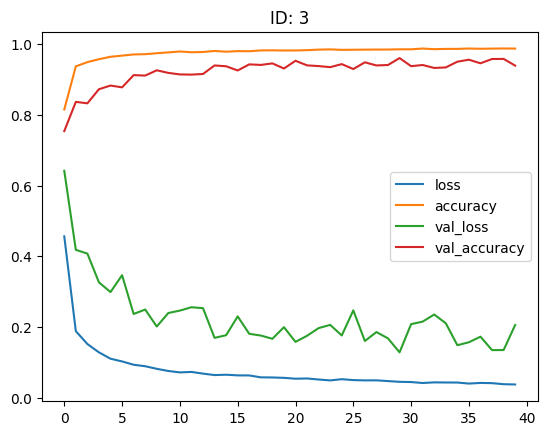

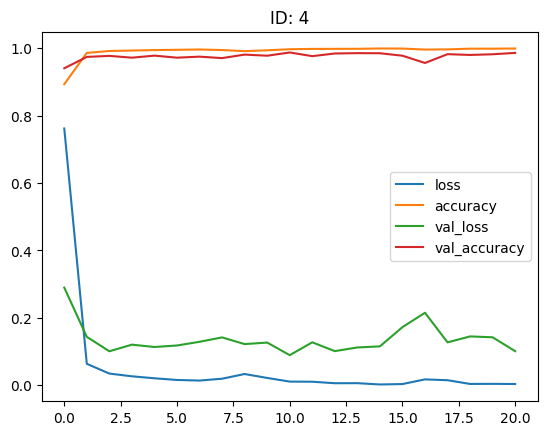

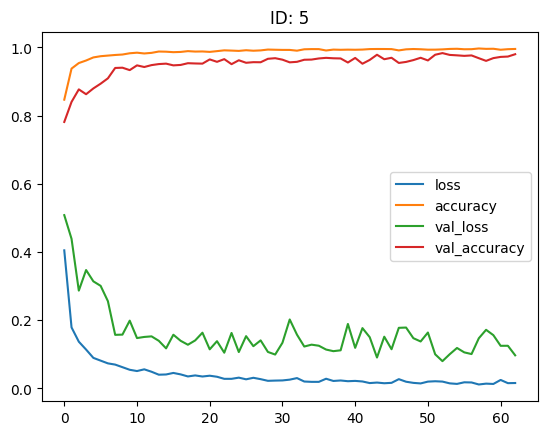

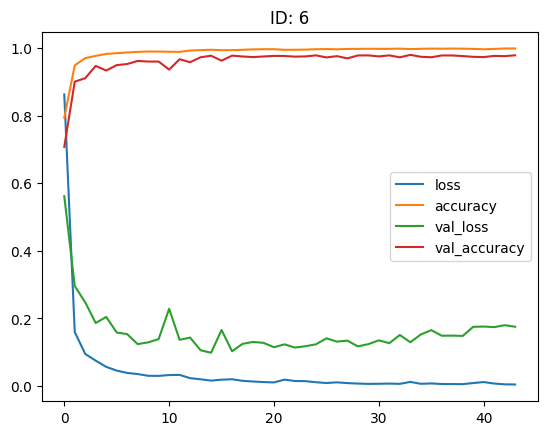

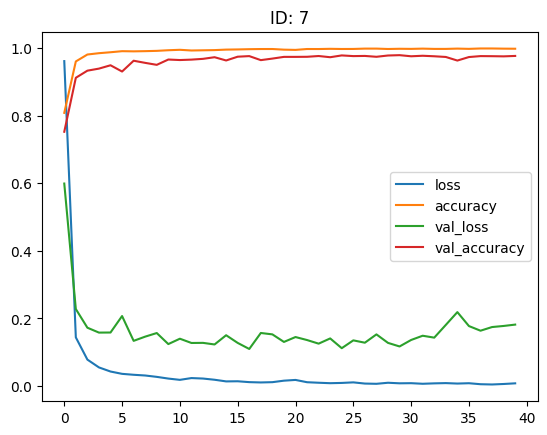

In [250]:
accuracies = [0]*len(tuner.oracle.trials)
losses = [0]*len(tuner.oracle.trials)
model = tuner.get_best_models()[0]
for id_trial, history in tuner.histories.items():
    pd.DataFrame(history).plot(title=f"ID: {id_trial}")
    accuracies[int(id_trial)] = history['val_accuracy']
    losses[int(id_trial)] = history['val_loss']    

,Dense,filter_0,kernel_size_0,nbConvolution,units_0,nbDense
Modèle 0,True,9,3,3,8,0
Modèle 1,False,6,5,2,56,1
Modèle 2,True,3,5,0,8,4
Modèle 3,False,9,3,4,24,3
Modèle 4,True,9,5,4,24,0
Modèle 5,False,6,5,3,24,2
Modèle 6,True,9,5,1,8,0
Modèle 7,True,3,5,0,8,0


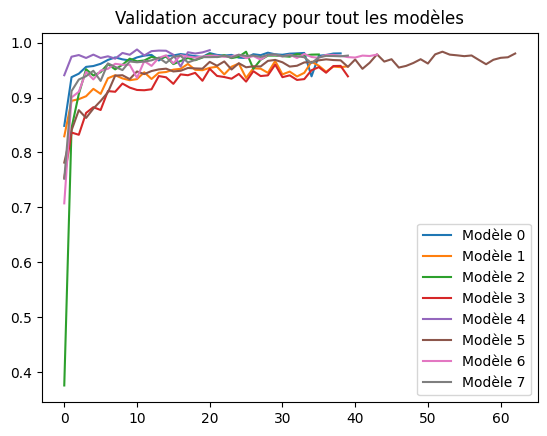

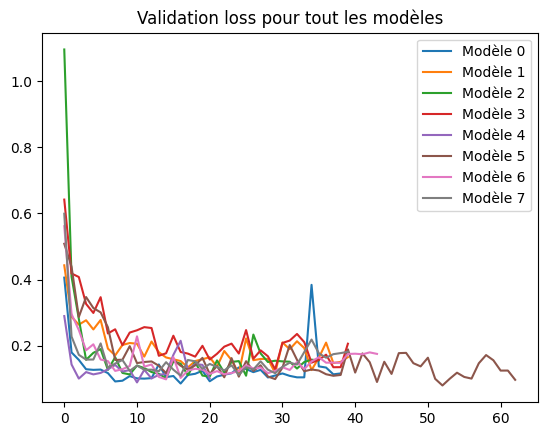

In [251]:
indexs = [] # On compare la precision et la loss de chaque modèle. Cela permet de constater les changements de precisions et de loss en fonction des modelès
hyperparameters = pd.DataFrame()
for i in range(len(tuner.oracle.trials)):
    indexs.append('Modèle '+str(i))
    hyperparameters['Modèle '+str(i)] = tuner.oracle.get_trial(str(i)).hyperparameters.values
pd.DataFrame(accuracies,index=indexs).T.plot(title="Validation accuracy pour tout les modèles",legend=True)
pd.DataFrame(losses,index=indexs).T.plot(title="Validation loss pour tout les modèles",legend=True)
hyperparameters.T

In [252]:
# On choisit de poursuivre avec l'essai 0.
# En effet les courbes de loss et val loss ainsi que accuracy et val accuracy
# se suivent encore ce qui signifie que le modèle n'a pas encore overfit.
# Il pourrait donc être plus propice à généraliser sur les données de test.

trial = tuner.oracle.get_trial("0")
chosen_model = tuner.hypermodel.build(trial.hyperparameters)
print(chosen_model.summary())
for layer in chosen_model.layers:
    if 'Dropout' in str(layer):
        config = layer.get_config()
        print(f"Dropout rate for {layer.name}: {config['rate']}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 51, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 2040)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16328     
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 16355 (63.89 KB)
Trainable params: 16355 (63.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [253]:
ourCallback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='max', baseline=None, restore_best_weights=True)
history = chosen_model.fit(train.X, train.y, epochs=1000, batch_size=256, validation_split=0.2, callbacks=[ourCallback], class_weight=class_weight)

Epoch 1/1000
62/62 [==============================] - 1s 4ms/step - loss: 6.8209 - accuracy: 0.7271 - val_loss: 1.3662 - val_accuracy: 0.6528
Epoch 2/1000
62/62 [==============================] - 0s 2ms/step - loss: 1.3198 - accuracy: 0.8959 - val_loss: 0.4741 - val_accuracy: 0.8348
Epoch 3/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.9503 - val_loss: 0.2361 - val_accuracy: 0.9202
Epoch 4/1000
62/62 [==============================] - 0s 3ms/step - loss: 0.3668 - accuracy: 0.9689 - val_loss: 0.1415 - val_accuracy: 0.9536
Epoch 5/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.2527 - accuracy: 0.9800 - val_loss: 0.1114 - val_accuracy: 0.9691
Epoch 6/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.1933 - accuracy: 0.9839 - val_loss: 0.0987 - val_accuracy: 0.9703
Epoch 7/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.9864 - val_loss: 0.0829 - val_accuracy: 0.9774
Epoch 

87/87 [==============================] - 0s 781us/step
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2377
           1       0.31      0.68      0.43       173
           2       0.33      0.63      0.44       224

    accuracy                           0.79      2774
   macro avg       0.54      0.71      0.58      2774
weighted avg       0.88      0.79      0.82      2774


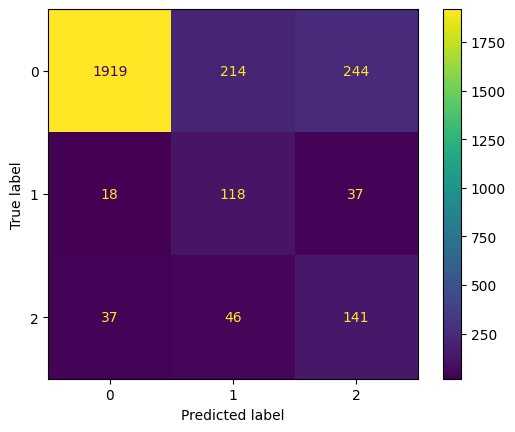

In [254]:
y_pred = chosen_model.predict(test.X)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test.y, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test.y, y_pred)).plot()

In [255]:
chosen_model.save(f"./models/Pong.keras")

In [256]:
best_model = tuner.get_best_models()[0]

In [257]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 51, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 2040)              0         
                                                                 
 dense (Dense)               (None, 24)                48984     
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 49059 (191.64 KB)
Trainable params: 49059 (191.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


87/87 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2377
           1       0.42      0.65      0.51       173
           2       0.45      0.62      0.52       224

    accuracy                           0.85      2774
   macro avg       0.61      0.72      0.65      2774
weighted avg       0.89      0.85      0.87      2774


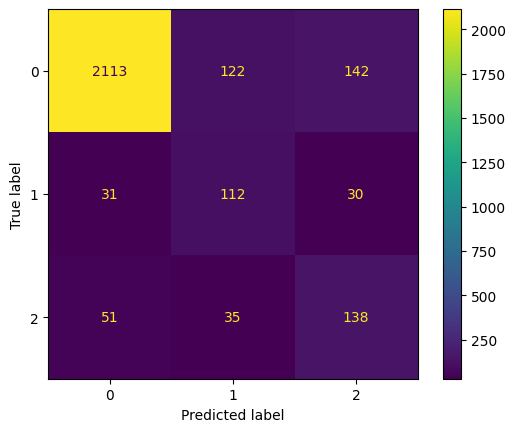

In [258]:
y_pred = best_model.predict(test.X)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test.y, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test.y, y_pred)).plot()

In [259]:
best_model.save(f"./models/pong-6.h5")

/home/theojeannes/Dev/Scolaire/AppParRenforcement/python/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
